
EVA 5 Session 8
=====================

## Cloning the reqiured module from GitHub.

In [3]:
!git clone "https://github.com/sahalk/eva.git"

fatal: destination path 'eva' already exists and is not an empty directory.


## Import the Network and the APIs required.

In [4]:
from eva.Session8.model import ResNet
from eva.Session8.loader import Loader

In [5]:
data_mean = (0.4914, 0.4822, 0.4465)
data_std_dev = (0.2470, 0.2435, 0.2616)

cifar = Loader(data_mean, data_std_dev)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog plane   cat truck


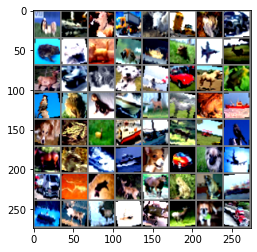

In [6]:
cifar.disp_image(cifar.trainloader)

In [7]:
cifar.print_sum()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [8]:
learning_rate = 0.01
momentum = 0.9
epoch = 30

cifar.train(epoch, learning_rate, learning_rate)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3561731576919556 Batch_id=781 Accuracy=45.85: 100%|██████████| 782/782 [01:07<00:00, 11.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4823, Accuracy: 4911/10000 (49.11%)

EPOCH: 1


Loss=1.2708719968795776 Batch_id=781 Accuracy=60.61: 100%|██████████| 782/782 [01:09<00:00, 11.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8414, Accuracy: 5069/10000 (50.69%)

EPOCH: 2


Loss=1.0722936391830444 Batch_id=781 Accuracy=67.59: 100%|██████████| 782/782 [01:09<00:00, 11.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0292, Accuracy: 6583/10000 (65.83%)

EPOCH: 3


Loss=0.6895200610160828 Batch_id=781 Accuracy=72.25: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7374, Accuracy: 7424/10000 (74.24%)

EPOCH: 4


Loss=0.33304986357688904 Batch_id=781 Accuracy=75.16: 100%|██████████| 782/782 [01:09<00:00, 11.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7015, Accuracy: 7600/10000 (76.00%)

EPOCH: 5


Loss=0.9321954250335693 Batch_id=781 Accuracy=77.54: 100%|██████████| 782/782 [01:09<00:00, 11.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7567, Accuracy: 7487/10000 (74.87%)

EPOCH: 6


Loss=0.6590303182601929 Batch_id=781 Accuracy=79.48: 100%|██████████| 782/782 [01:09<00:00, 11.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6518, Accuracy: 7759/10000 (77.59%)

EPOCH: 7


Loss=0.21056948602199554 Batch_id=781 Accuracy=80.85: 100%|██████████| 782/782 [01:09<00:00, 11.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6338, Accuracy: 7871/10000 (78.71%)

EPOCH: 8


Loss=0.6755434274673462 Batch_id=781 Accuracy=81.86: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7104, Accuracy: 7734/10000 (77.34%)

EPOCH: 9


Loss=0.8136097192764282 Batch_id=781 Accuracy=83.06: 100%|██████████| 782/782 [01:09<00:00, 11.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6150, Accuracy: 7894/10000 (78.94%)

EPOCH: 10


Loss=0.5934487581253052 Batch_id=781 Accuracy=84.08: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6779, Accuracy: 7828/10000 (78.28%)

EPOCH: 11


Loss=0.4564284384250641 Batch_id=781 Accuracy=84.89: 100%|██████████| 782/782 [01:09<00:00, 11.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5269, Accuracy: 8202/10000 (82.02%)

EPOCH: 12


Loss=0.6261530518531799 Batch_id=781 Accuracy=85.50: 100%|██████████| 782/782 [01:09<00:00, 11.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7663, Accuracy: 7616/10000 (76.16%)

EPOCH: 13


Loss=1.0987149477005005 Batch_id=781 Accuracy=86.33: 100%|██████████| 782/782 [01:09<00:00, 11.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5733, Accuracy: 8091/10000 (80.91%)

EPOCH: 14


Loss=0.5983399152755737 Batch_id=781 Accuracy=86.83: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5659, Accuracy: 8145/10000 (81.45%)

EPOCH: 15


Loss=0.6452332139015198 Batch_id=781 Accuracy=87.66: 100%|██████████| 782/782 [01:09<00:00, 11.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5289, Accuracy: 8272/10000 (82.72%)

EPOCH: 16


Loss=0.23521995544433594 Batch_id=781 Accuracy=88.05: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4579, Accuracy: 8527/10000 (85.27%)

EPOCH: 17


Loss=0.5743497014045715 Batch_id=781 Accuracy=88.50: 100%|██████████| 782/782 [01:09<00:00, 11.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5513, Accuracy: 8262/10000 (82.62%)

EPOCH: 18


Loss=0.5593741536140442 Batch_id=781 Accuracy=89.26: 100%|██████████| 782/782 [01:09<00:00, 11.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6065, Accuracy: 8199/10000 (81.99%)

EPOCH: 19


Loss=0.39556288719177246 Batch_id=781 Accuracy=89.54: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5032, Accuracy: 8449/10000 (84.49%)

EPOCH: 20


Loss=0.27023398876190186 Batch_id=781 Accuracy=89.78: 100%|██████████| 782/782 [01:09<00:00, 11.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4475, Accuracy: 8570/10000 (85.70%)

EPOCH: 21


Loss=0.36070311069488525 Batch_id=781 Accuracy=90.32: 100%|██████████| 782/782 [01:09<00:00, 11.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4542, Accuracy: 8570/10000 (85.70%)

EPOCH: 22


Loss=0.14928485453128815 Batch_id=781 Accuracy=90.72: 100%|██████████| 782/782 [01:09<00:00, 11.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4176, Accuracy: 8657/10000 (86.57%)

EPOCH: 23


Loss=0.29992666840553284 Batch_id=781 Accuracy=91.10: 100%|██████████| 782/782 [01:09<00:00, 11.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4126, Accuracy: 8635/10000 (86.35%)

EPOCH: 24


Loss=0.320011168718338 Batch_id=781 Accuracy=91.37: 100%|██████████| 782/782 [01:09<00:00, 11.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5775, Accuracy: 8305/10000 (83.05%)

EPOCH: 25


Loss=0.06976776570081711 Batch_id=781 Accuracy=91.54: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5326, Accuracy: 8429/10000 (84.29%)

EPOCH: 26


Loss=0.053768739104270935 Batch_id=781 Accuracy=91.96: 100%|██████████| 782/782 [01:09<00:00, 11.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4018, Accuracy: 8729/10000 (87.29%)

EPOCH: 27


Loss=0.17723654210567474 Batch_id=781 Accuracy=92.15: 100%|██████████| 782/782 [01:09<00:00, 11.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3975, Accuracy: 8760/10000 (87.60%)

EPOCH: 28


Loss=0.15280967950820923 Batch_id=781 Accuracy=92.62: 100%|██████████| 782/782 [01:09<00:00, 11.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4693, Accuracy: 8609/10000 (86.09%)

EPOCH: 29


Loss=0.5578396916389465 Batch_id=781 Accuracy=92.71: 100%|██████████| 782/782 [01:09<00:00, 11.19it/s]
100%|██████████| 157/157 [00:03<00:00, 47.55it/s]


Test set: Average loss: 0.5025, Accuracy: 8486/10000 (84.86%)

